<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Variance-Thresholding" data-toc-modified-id="Variance-Thresholding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Variance Thresholding</a></span></li><li><span><a href="#Anova-Test" data-toc-modified-id="Anova-Test-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Anova Test</a></span></li><li><span><a href="#RFE-(Recursive-Feature-Elimination)" data-toc-modified-id="RFE-(Recursive-Feature-Elimination)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>RFE (Recursive Feature Elimination)</a></span></li><li><span><a href="#Feature-Selection-using-RandomForest" data-toc-modified-id="Feature-Selection-using-RandomForest-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Feature Selection using RandomForest</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Scorer-=-F1---weighted" data-toc-modified-id="Scorer-=-F1---weighted-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Scorer = <code>F1 - weighted</code></a></span></li><li><span><a href="#Decision-tree-modelling" data-toc-modified-id="Decision-tree-modelling-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Decision tree modelling</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning-the-decision-tree" data-toc-modified-id="Hyperparameter-tuning-the-decision-tree-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Hyperparameter tuning the decision tree</a></span></li></ul></li><li><span><a href="#Modelling-with-Random-Forest" data-toc-modified-id="Modelling-with-Random-Forest-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Modelling with Random Forest</a></span><ul class="toc-item"><li><span><a href="#Tuning-the-Random-Forest" data-toc-modified-id="Tuning-the-Random-Forest-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Tuning the Random Forest</a></span></li></ul></li><li><span><a href="#Saving-both-the-models-and-the-results" data-toc-modified-id="Saving-both-the-models-and-the-results-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Saving both the models and the results</a></span></li></ul></li></ul></div>

<center><h1>Feature Selection</h1></center>

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv

from sklearn.preprocessing import (
    MinMaxScaler, 
    StandardScaler
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

from sklearn.model_selection import (
    train_test_split, 
    KFold, StratifiedKFold, GridSearchCV,
    HalvingGridSearchCV, cross_validate
)

from sklearn.feature_selection import (
    VarianceThreshold, 
    f_classif,
    SelectKBest,
    SelectFromModel,
    RFE
)

from imblearn import (
    over_sampling, 
    under_sampling,
    ensemble
)
from imblearn.metrics import sensitivity_specificity_support, classification_report_imbalanced

from skopt import BayesSearchCV

from joblib import dump, load

from prettytable import PrettyTable

sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)

np.random.seed(42)

In [34]:
df = pd.read_csv("./DryBeanDataset/Dry_Bean_Dataset.csv").sample(frac=1).reset_index(drop=True)

In [35]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,42339,741.226,260.199330,207.306394,1.255144,0.604347,42676,232.180294,0.771202,0.992103,0.968387,0.892317,0.006146,0.002403,0.796230,0.999383,SEKER
1,68247,1088.754,370.368146,237.863792,1.557060,0.766507,70172,294.779204,0.767683,0.972567,0.723492,0.795909,0.005427,0.001343,0.633471,0.986352,BARBUNYA
2,37856,708.716,248.430330,194.360324,1.278195,0.622835,38232,219.544429,0.744640,0.990165,0.947109,0.883726,0.006563,0.002469,0.780972,0.998235,SEKER
3,33143,648.385,222.526309,189.737379,1.172812,0.522480,33377,205.423899,0.769980,0.992989,0.990685,0.923144,0.006714,0.003008,0.852195,0.999465,SEKER
4,29925,647.570,237.714031,161.004849,1.476440,0.735703,30321,195.196551,0.785309,0.986940,0.896748,0.821140,0.007944,0.002228,0.674271,0.995521,DERMASON


In [36]:
X = df.drop('Class', axis=1)
y = df['Class'].astype('category').cat.codes

In [37]:
X.var(numeric_only=True)

Area               8.599026e+08
Perimeter          4.592007e+04
MajorAxisLength    7.343494e+03
MinorAxisLength    2.022309e+03
AspectRation       6.085026e-02
Eccentricity       8.464324e-03
ConvexArea         8.865456e+08
EquivDiameter      3.501932e+03
Extent             2.409471e-03
Solidity           2.171913e-05
roundness          3.542617e-03
Compactness        3.808552e-03
ShapeFactor1       1.272380e-06
ShapeFactor2       3.550668e-07
ShapeFactor3       9.800238e-03
ShapeFactor4       1.906595e-05
dtype: float64

In [38]:
scaler = MinMaxScaler(feature_range=(1, 10))
X_scaled = scaler.fit_transform(X)

In [39]:
X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns[:-1].tolist())

In [40]:
X_scaled_df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,1.842333,2.333948,2.241553,3.259922,2.474618,6.008954,1.815939,2.564276,7.249960,9.692861,9.599492,7.534442,4.949932,6.338256,7.153161,9.939511
1,2.837961,4.475314,4.027241,4.074337,4.407996,8.116537,2.836085,3.944692,7.148074,7.361961,5.200767,5.031962,4.106907,3.261495,4.557913,7.686064
2,1.670054,2.133631,2.050793,2.914883,2.622229,6.249241,1.651059,2.285633,6.480978,9.461633,9.217301,7.311453,5.438912,6.528719,6.909876,9.740964
3,1.488937,1.761889,1.630924,2.791673,1.947392,4.944941,1.470931,1.974250,7.214565,9.798561,10.000000,8.334629,5.616748,8.092549,8.045553,9.953770
4,1.365271,1.756867,1.877097,2.025894,3.891733,7.716176,1.357548,1.748719,7.658365,9.076779,8.312734,5.686900,7.058892,5.828550,5.208494,9.271746


In [41]:
X_scaled_df.var()

Area               1.269917
Perimeter          1.743431
MajorAxisLength    1.929286
MinorAxisLength    1.436504
AspectRation       2.495305
Eccentricity       1.429793
ConvexArea         1.220357
EquivDiameter      1.702920
Extent             2.019396
Solidity           0.309189
roundness          1.142924
Compactness        2.566088
ShapeFactor1       1.750466
ShapeFactor2       2.991209
ShapeFactor3       2.491745
ShapeFactor4       0.570142
dtype: float64

## Variance Thresholding

If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed.

Variance will also be very low for a feature if only a handful of observations of that feature differ from a constant value.

What we can do is set a threshold and drop features with low variance 

In [42]:
vt = VarianceThreshold(threshold=1)
X_scaled_var_feats = vt.fit_transform(X_scaled)

In [43]:
X_scaled_var_feats_df = pd.DataFrame(
    X_scaled_var_feats, 
    columns=X_scaled_df.columns[vt.get_support(indices=True)]
)

In [44]:
X_scaled_var_feats_df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3
0,1.842333,2.333948,2.241553,3.259922,2.474618,6.008954,1.815939,2.564276,7.249960,9.599492,7.534442,4.949932,6.338256,7.153161
1,2.837961,4.475314,4.027241,4.074337,4.407996,8.116537,2.836085,3.944692,7.148074,5.200767,5.031962,4.106907,3.261495,4.557913
2,1.670054,2.133631,2.050793,2.914883,2.622229,6.249241,1.651059,2.285633,6.480978,9.217301,7.311453,5.438912,6.528719,6.909876
3,1.488937,1.761889,1.630924,2.791673,1.947392,4.944941,1.470931,1.974250,7.214565,10.000000,8.334629,5.616748,8.092549,8.045553
4,1.365271,1.756867,1.877097,2.025894,3.891733,7.716176,1.357548,1.748719,7.658365,8.312734,5.686900,7.058892,5.828550,5.208494


**Obvservation**

 - As we can see 2 low variance features are removed which are `Solidity` and `ShapeFactor4`

## Anova Test

Analysis of variance (ANOVA) is a statistical technique that is used to check if the means of two or more groups are significantly different from each other. ANOVA checks the impact of one or more factors by comparing the means of different samples. 

If we had categorical variables we would do another test called the $\chi^2$ test. Since we have all numeric features we do the ANOVA test.

In [45]:
anova_filter = SelectKBest(score_func=f_classif, k=8)
anova_filter.fit(X, y)

SelectKBest(k=8)

In [46]:
anova_df = pd.DataFrame({
    'features': df.columns[anova_filter.get_support(indices=True)],
    'scores': anova_filter.scores_[anova_filter.get_support(indices=True)]
})

In [47]:
anova_df

,features,scores
0,Area,29017.510462
1,Perimeter,24283.663708
2,MajorAxisLength,21622.237935
3,MinorAxisLength,22442.386382
4,ConvexArea,28961.791217
5,EquivDiameter,25444.547794
6,ShapeFactor1,12081.321137
7,ShapeFactor2,12329.884201


**Obvservation**

 - We have selected 8 best features according to the anova scores. 
 - We can select more features also, it can be a thought of as a hyperparameter to be tuned i.e trying different models with different number of features
 - I selected the number 8 as in the previous EDA notebook we saw that 8 principal components could be used to describe the whole dataset

## RFE (Recursive Feature Elimination)

Recursive Feature Elimination selects features by recursively considering smaller subsets of features by pruning the least important feature at each step. Here models are created iteartively and in each iteration it determines the best and worst performing features and this process continues until all the features are explored.Next ranking is given on eah feature based on their elimination orde. In the worst case, if a dataset contains N number of features RFE will do a greedy search for $N^2$ combinations of features.

In [48]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8, verbose=3)
rfe.fit(X, y)

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8, verbose=3)

In [49]:
rfe.get_feature_names_out()

array(['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'roundness',
       'Compactness', 'ShapeFactor1', 'ShapeFactor3', 'ShapeFactor4'],
      dtype=object)

In [50]:
rfe_df = pd.DataFrame(
    {
        'features': X.columns.to_list(),
        'rank': rfe.ranking_,
        'selected': rfe.support_
    }
)

In [51]:
rfe_df

,features,rank,selected
0,Area,8,False
1,Perimeter,1,True
2,MajorAxisLength,1,True
3,MinorAxisLength,1,True
4,AspectRation,9,False
5,Eccentricity,7,False
6,ConvexArea,5,False
7,EquivDiameter,3,False
8,Extent,4,False
9,Solidity,2,False


**Obvservation**

 - We can see that the ones which are marked as `True` are the features selected.

## Feature Selection using RandomForest

Feature selection using Random forest comes under the category of Embedded methods. Embedded methods combine the qualities of filter and wrapper methods. They are implemented by algorithms that have their own built-in feature selection methods. Some of the benefits of embedded methods are :

1. They are highly accurate.
2. They generalize better.
3. They are interpretable

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [53]:
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=-1))
selector.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


SelectFromModel(estimator=RandomForestClassifier(n_jobs=-1, verbose=1))

In [54]:
print(f"Selected features are: {selector.get_feature_names_out()}")

Selected features are: ['Area' 'Perimeter' 'MajorAxisLength' 'MinorAxisLength' 'AspectRation'
 'ConvexArea' 'Compactness' 'ShapeFactor1' 'ShapeFactor3']


## Conclusion

I now enlist all the methods used and the features selected

In [55]:
methods = [
    'Variance Thresholding (threshold = 1)',
    'ANOVA F-test',
    'Recursive Feature Elimination (estimator = DecisionTreeClassifier)',
    'Using RandomForest feature importance'
]

features = [
    X_scaled_var_feats_df.columns.to_list(),
    df.columns[anova_filter.get_support(indices=True)].to_list(),
    rfe.get_feature_names_out().tolist(),
    selector.get_feature_names_out().tolist()
]

In [56]:
table = PrettyTable(['Methods', 'Features Selected'])
for m, f in zip(methods, features):
    table.add_row([m, f])

In [57]:
table

Methods,Features Selected
Variance Thresholding (threshold = 1),"['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3']"
ANOVA F-test,"['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'EquivDiameter', 'ShapeFactor1', 'ShapeFactor2']"
Recursive Feature Elimination (estimator = DecisionTreeClassifier),"['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor3', 'ShapeFactor4']"
Using RandomForest feature importance,"['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'ConvexArea', 'Compactness', 'ShapeFactor1', 'ShapeFactor3']"


# Modelling

Let's start with features selected using the ANOVA F-test

Our metric of choice is going to be `Weighted F1-score`. 
Here's a very good explanation for it: [link](https://stats.stackexchange.com/questions/463224/which-performance-metrics-for-highly-imbalanced-multiclass-dataset) 

In [27]:
def plot_cf(cf):
    classes = df.Class.astype("category").cat.categories.tolist()
    _ = sns.heatmap(cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d", cmap="viridis_r")

In [28]:
feats = anova_filter.get_feature_names_out().tolist()

In [29]:
X[feats].head(10)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,ConvexArea,EquivDiameter,ShapeFactor1,ShapeFactor2
0,42339,741.226,260.199330,207.306394,42676,232.180294,0.006146,0.002403
1,68247,1088.754,370.368146,237.863792,70172,294.779204,0.005427,0.001343
2,37856,708.716,248.430330,194.360324,38232,219.544429,0.006563,0.002469
3,33143,648.385,222.526309,189.737379,33377,205.423899,0.006714,0.003008
4,29925,647.570,237.714031,161.004849,30321,195.196551,0.007944,0.002228
5,38489,707.978,244.119399,200.950084,38782,221.372349,0.006343,0.002646
6,89592,1155.357,452.291405,254.964533,90627,337.745581,0.005048,0.000968
7,42379,759.965,251.037567,215.217912,42840,232.289945,0.005924,0.002679
8,203536,1735.247,648.157318,401.698875,206049,509.067858,0.003184,0.000747
9,27306,608.784,225.492411,154.595717,27648,186.459323,0.008258,0.002382


In [30]:
# anova.to_csv('./selected_features/Anova.csv', index=False)

In [31]:
X_ = X[feats]
y_ = y

## Scorer = `F1 - weighted`

In [58]:
scorer = metrics.make_scorer(
    metrics.f1_score, average='weighted'
)

In [62]:
def print_score(results):
    print(
        f"F1-score (weighted) mean +/- std. dev.: "
        f"{results['test_score'].mean():.3f} +/- "
        f"{results['test_score'].std():.3f}"
    )
    
    return results['estimator'][-1]

## Decision tree modelling

In [63]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.3, stratify=y_)

dt = DecisionTreeClassifier()
results = cross_validate(
    estimator=dt, 
    X=X_train_, 
    y=y_train_, 
    scoring=scorer, 
    cv=StratifiedKFold(n_splits=10), 
    verbose=2, 
    n_jobs=-1,
    return_estimator=True 
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [64]:
model = print_score(results=results)

F1-score (weighted) mean +/- std. dev.: 0.880 +/- 0.010


In [65]:
# Predicting on the test data

preds = model.predict(X_test_)
print(f"Prediction from the baseline model, F1-score: {metrics.f1_score(preds, y_test_, average='weighted')}")

Prediction from the baseline model, F1-score: 0.877821561924996


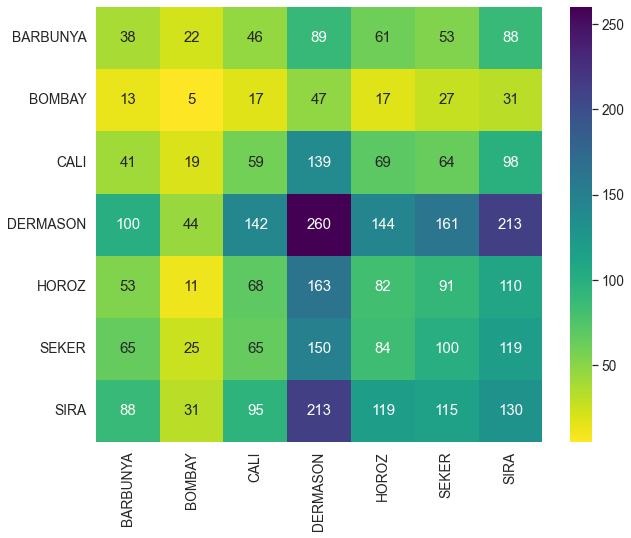

In [66]:
cf = metrics.confusion_matrix(y_true=y_test, y_pred=preds)
plot_cf(cf)

### Hyperparameter tuning the decision tree

A very good guide to tuning the decision tree and it's various parameters I refered to is: [How to tune a Decision Tree ?](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)

In [67]:
params_dt = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': ['sqrt', 'auto', 'log2'],
    'criterion': ["gini", "entropy"],
    'splitter': ['best', 'random']
}

In [68]:
gs_cv_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(), n_jobs=-1,
    param_grid=params_dt, scoring=scorer, cv=StratifiedKFold(n_splits=10), verbose=10, 
)

In [69]:
%%time
gs_cv_dt.fit(X_train_, y_train_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Wall time: 9.22 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'splitter': ['best', 'random']},
             scoring=make_scorer(f1_score, average=weighted), verbose=10)

In [70]:
gs_cv_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 10,
 'splitter': 'best'}

In [71]:
gs_cv_dt_df = pd.DataFrame(gs_cv_dt.cv_results_)
gs_cv_dt_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_splitter,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014200,0.004954,0.004403,0.000663,gini,2,sqrt,5,best,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.588758,0.482065,0.577710,0.513512,0.488598,0.565203,0.494338,0.536852,0.037627,205
1,0.008799,0.005094,0.004300,0.000900,gini,2,sqrt,5,random,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.174232,0.224280,0.338464,0.303031,0.241705,0.187004,0.290286,0.265510,0.064358,297
2,0.011299,0.001007,0.003601,0.000491,gini,2,sqrt,10,best,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.483336,0.527768,0.498437,0.555702,0.470542,0.541888,0.536786,0.515567,0.031696,211
3,0.006600,0.001428,0.003900,0.000541,gini,2,sqrt,10,random,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.221302,0.326103,0.321830,0.247466,0.386005,0.323977,0.332847,0.298423,0.047384,286
4,0.012700,0.002147,0.004101,0.001375,gini,2,sqrt,20,best,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.415630,0.489028,0.459334,0.501155,0.390132,0.392470,0.503755,0.453130,0.043588,248


In [72]:
gs_cv_dt_df.nlargest(5, columns=['mean_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_splitter,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
262,0.065002,0.001553,0.002998,0.000009,entropy,10,log2,10,best,"{'criterion': 'entropy', 'max_depth': 10, 'max...",...,0.899932,0.887115,0.884034,0.893298,0.897420,0.886432,0.892083,0.893483,0.007226,1
114,0.034499,0.003528,0.003700,0.000640,gini,10,log2,20,best,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",...,0.886913,0.895639,0.872710,0.893174,0.885980,0.884133,0.879313,0.888164,0.012206,2
112,0.035299,0.001735,0.003400,0.000663,gini,10,log2,10,best,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",...,0.881437,0.898968,0.862994,0.881972,0.890903,0.892251,0.887051,0.887573,0.013161,3
292,0.072999,0.004605,0.003201,0.000401,entropy,20,log2,10,best,"{'criterion': 'entropy', 'max_depth': 20, 'max...",...,0.893429,0.897490,0.871696,0.884700,0.891185,0.898278,0.874478,0.887194,0.010022,4
282,0.048699,0.002051,0.003201,0.000400,entropy,20,auto,10,best,"{'criterion': 'entropy', 'max_depth': 20, 'max...",...,0.862920,0.896513,0.880474,0.883282,0.889366,0.888107,0.879916,0.887159,0.012746,5


In [73]:
tuned_model = gs_cv_dt.best_estimator_

Fitting the best estimator after tuning

In [74]:
preds = tuned_model.predict(X_test_)
print(f"Prediction from the best model, F1-score: {metrics.f1_score(preds, y_test_, average='weighted')}")

Prediction from the best model, F1-score: 0.8870413368608534


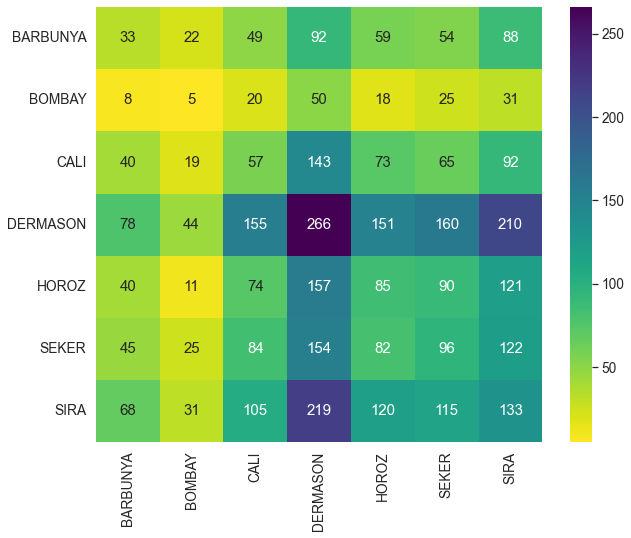

In [75]:
cf = metrics.confusion_matrix(y_true=y_test, y_pred=preds)
plot_cf(cf)

**Obvservation**

- After hyperparamter tuning we can clearly see a improvement in our model without any under-sampling or over-sampling
- With the default `DecisionTreeClassifier` we get approx ~ 0.87 weighted f1-score.
- After tuning we are now getting approx ~ 0.89 weighted f1-score.

## Modelling with Random Forest

In [76]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced')
results = cross_validate(
    estimator=dt, 
    X=X_train_, 
    y=y_train_, 
    scoring=scorer, 
    cv=StratifiedKFold(n_splits=10), 
    verbose=1, 
    n_jobs=1,
    return_estimator=True 
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [77]:
preds = results['estimator'][-1].predict(X_test_)
print(f"Prediction from the baseline model, F1-score: {metrics.f1_score(preds, y_test_, average='weighted')}")

Prediction from the baseline model, F1-score: 0.8762375772213905


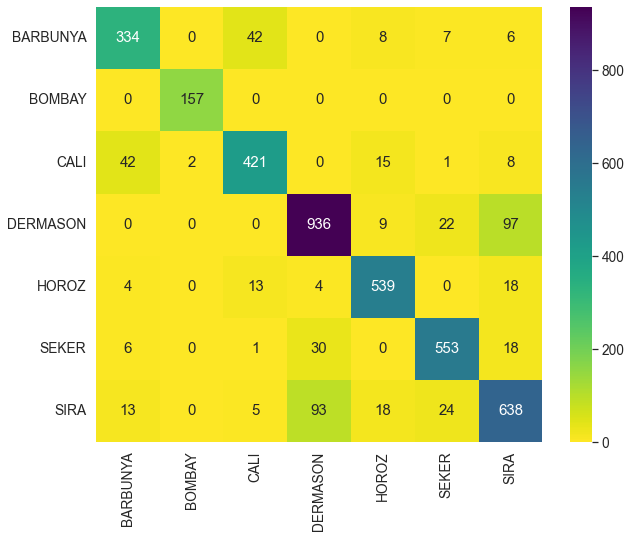

In [78]:
cf = metrics.confusion_matrix(y_test_, preds)
plot_cf(cf)

### Tuning the Random Forest

We have already seen `HalvingGridSearchCV` for tuning the decision tree. We will now use `BayesSearchCV` which is a better way and more efficient way to tune the hyper parameters rather than just trying every possible combination. 

The one-sentence summary of Bayesian hyperparameter optimization is: build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

Detailed explanation in: [A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)

In [80]:
params_rf = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400, 600],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [81]:
bs_cv_rf = BayesSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1), 
    search_spaces=params_rf, n_iter=20,
    cv=StratifiedKFold(n_splits=10), verbose=2, scoring=scorer
)

In [82]:
%%time
bs_cv_rf.fit(X_train_, y_train_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200

[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.9s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400

[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=1, m

[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
Wall time: 4min 48s


BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
              estimator=RandomForestClassifier(n_jobs=-1), n_iter=20,
              scoring=make_scorer(f1_score, average=weighted),
              search_spaces={'bootstrap': [True, False],
                             'class_weight': ['balanced', 'balanced_subsample'],
                             'max_depth': [10, 20, 30, 40, 50],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': [1, 2, 4],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [100, 200, 400, 600]},
              verbose=2)

In [83]:
bs_cv_rf.best_params_

OrderedDict([('bootstrap', True),
             ('class_weight', 'balanced_subsample'),
             ('max_depth', 30),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 10),
             ('n_estimators', 400)])

In [84]:
bs_cv_rf.best_score_

0.9090547834358352

In [85]:
best_model = bs_cv_rf.best_estimator_

In [86]:
preds = best_model.predict(X_test_)
print(f"Prediction from the tuned model, F1-score: {metrics.f1_score(preds, y_test_, average='weighted')}")

Prediction from the tuned model, F1-score: 0.9119965333209641


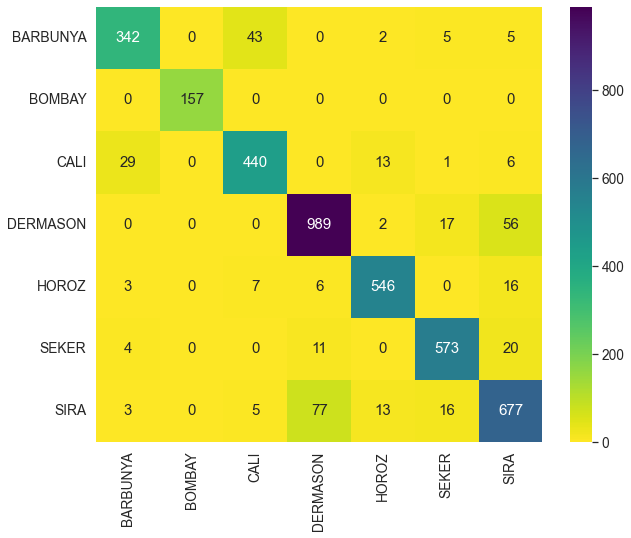

In [87]:
cf = metrics.confusion_matrix(y_test_, best_model.predict(X_test_))
plot_cf(cf)

In [90]:
print(classification_report_imbalanced(y_test_, preds, target_names=np.unique(df.Class.values)))

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.90      0.86      0.99      0.88      0.92      0.84       397
     BOMBAY       1.00      1.00      1.00      1.00      1.00      1.00       157
       CALI       0.89      0.90      0.98      0.89      0.94      0.88       489
   DERMASON       0.91      0.93      0.97      0.92      0.95      0.90      1064
      HOROZ       0.95      0.94      0.99      0.95      0.97      0.93       578
      SEKER       0.94      0.94      0.99      0.94      0.97      0.93       608
       SIRA       0.87      0.86      0.97      0.86      0.91      0.82       791

avg / total       0.91      0.91      0.98      0.91      0.95      0.89      4084



**Obvservation**

- After hyperparamter tuning we can clearly see a improvement in our model without any under-sampling or over-sampling
- With the default `RandomForestClassifier` we get approx ~ 0.876 weighted f1-score.
- After tuning we are now getting approx ~ 0.91 weighted f1-score, this is massive!

## Saving both the models and the results

In [91]:
dump(gs_cv_dt.best_estimator_, './ML_models/DecisionTree-tuned.joblib')
dump(bs_cv_rf.best_estimator_, './ML_models/RandomForest-tuned.joblib')

['./ML_models/RandomForest-tuned.joblib']

In [92]:
gs_cv_dt_df.to_csv('./ML_results/DecisionTree_GridSearchCV_results.csv', index=False)

In [93]:
bs_cv_rf_df = pd.DataFrame(bs_cv_rf.cv_results_)
bs_cv_rf_df.to_csv('./ML_results/RandomForest_BayesSearchCV_results.csv', index=False)